# Topic Modelling

In [1]:
# import libraries
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = os.path.join(BASE_DIR, 'cache')
memory = Memory(cachedir, verbose=0)

In [3]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [5]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.102*"host" + 0.050*"stay" + 0.046*"great" + 0.037*"place" + 0.033*"apartment" + 0.031*"location" + 0.027*"recommend" + 0.025*"nice" + 0.023*"clean" + 0.019*"really"'),
 (1,
  '0.034*"apartment" + 0.031*"walk" + 0.029*"close" + 0.024*"city" + 0.022*"station" + 0.020*"nice" + 0.019*"restaurant" + 0.017*"minute" + 0.016*"stay" + 0.015*"great"'),
 (2,
  '0.017*"room" + 0.015*"bed" + 0.013*"kitchen" + 0.012*"good" + 0.012*"apartment" + 0.010*"small" + 0.010*"bathroom" + 0.009*"work" + 0.008*"get" + 0.008*"thing"')]

In [7]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # create a dataframe
    sent_topics_df = pd.DataFrame(columns=['dominant_topic', 'percent_contribution', 'topic_keywords'])

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,3), topic_keywords]
            else:
                break


    # merge the original dataframe to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.sample(3)

,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments_language,description_language,dominant_topic,percent_contribution,topic_keywords,text
67151,2022-07-19,2320.0,6.491045e+17,353113929.0,Hannah,great apartment good location exploring stockh...,377787159.0,Erik,new cozy place södermalm welcome cozy apartmen...,Södermalm,...,4.80,4.86,4.69,4.37,en,en,0,0.524,"host, stay, great, place, apartment, location,...","[great, apartment, good, location, explore, qu..."
3359,2016-07-23,14.0,3.857010e+05,2055868.0,Tijs,wonderful stay stylishly decorated quiet home ...,1930434.0,Alex,terrace house stockholm farsta one finest arch...,Farsta,...,4.71,4.71,4.14,4.14,en,en,0,0.444,"host, stay, great, place, apartment, location,...","[wonderful, stay, quiet, home, host, house, lo..."
13206,2018-06-02,278.0,6.639610e+06,26230368.0,Todd,bright clean flat amazing fifthfloor view host...,6977292.0,Aleksandra,cozy studio amazing view nytorget former artis...,Södermalm,...,4.92,4.95,4.98,4.78,en,en,1,0.529,"apartment, walk, close, city, station, nice, r...","[bright, clean, flat, amazing, fifthfloor, vie..."


In [8]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.121086  0.190647       1        1  43.256976
1     -0.159958 -0.173843       2        1  29.076584
2      0.281044 -0.016804       3        1  27.666440, topic_info=        Term          Freq         Total Category  logprob  loglift
28      host  59704.000000  59704.000000  Default  30.0000  30.0000
88      walk  12211.000000  12211.000000  Default  29.0000  29.0000
70     close  11444.000000  11444.000000  Default  28.0000  28.0000
8      great  32988.000000  32988.000000  Default  27.0000  27.0000
158  station   8500.000000   8500.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
38     clean   2322.519365  20119.870387   Topic3  -5.0859  -0.8741
35      stay   2394.896036  38368.441297   Topic3  -5.0552  -1.4889
50      need   1986.239776  11865.600427   Topic3  -5.2423  -0.5025
90     check   1822.033943   5528.230641   Topic3  -5.3286   0.1750
159     well   1831.715589  12458.629342   Topic3  -5.3233  -0.6322

[190 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
675       2  0.000998         able
675       3  0.998650         able
622       1  0.999712  accommodate
116       1  0.960745       always
116       3  0.039055       always
...     ...       ...          ...
159       3  0.147047         well
587       2  0.000922         wifi
587       3  0.999116         wifi
866       3  0.999242       window
601       3  0.999738         work

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [10]:
topics = lda_model.show_topics(formatted=False)

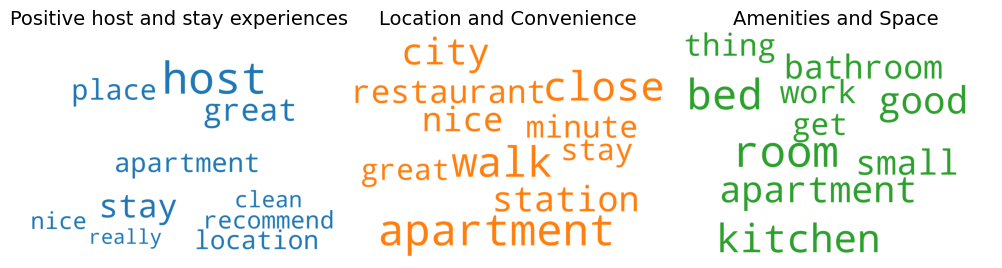

<Figure size 640x480 with 0 Axes>

In [16]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Positive host and stay experiences',
          1: 'Location and Convenience',
          2: 'Amenities and Space'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=20)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig('topics_all.png')